# Train

In [72]:
import os
from box import Box
import torch.optim as optim

from utils import random_seed, sparse2Tensor
from dataset import VAEData
from trainer import Trainer
from model import VAE

##############################ARGS##################################
args = {
    ######data#######
    'min_user_cnt' : 5,
    'min_movie_cnt' : 0,
    'n_heldout' : 3000,
    'target_prop' : 0.2,
    'min_movie_to_split' : 5,
    
    #####model######
    'hidden_dim' : 600, # 600
    'latent_dim' : 200, # 200
    'stnd_mixture_weight' : 3/20,
    'post_mixture_weight' : 3/4,
    'unif_mixture_weight' : 1/10,
    'dropout_ratio' : 0.5,
    
    #####optimizer####
    'lr' : 1e-4,
    'wd' : 0.00,
    
    ######trainer#####
    'batch_size' : 256, #256
    'epochs' : 100, #100
    'en_epochs' : 3, #3
    'de_epochs' : 1, #1
    'beta' : None,
    'gamma' : 0.005, #0.005
    'not_alter' : False,
    'ndcg_k' : 50,
    'recall_k' : 20,
    'verbose' : True,
    
    #####etc#######
    'base_dir' : '/opt/ml/input/data/',
    'random_seed' : 42,
    'device' : 'cuda'
}
args = Box(args)
##############################ARGS##################################

##############################PATHS##################################
dir_data = os.path.join(args.base_dir, 'train')
path_rating = os.path.join(dir_data, 'train_ratings.csv')
dir_output = os.path.join(os.getcwd(), 'output')
dir_preprocessing = os.path.join(os.getcwd(), 'data')

dir_file_path = {
    'dir_base': args.base_dir,
    'dir_data': dir_data,
    'rating': path_rating,
    'dir_output': dir_output,
    'dir_preprocessing' : dir_preprocessing
}
dir = Box(dir_file_path)
##############################PATHS##################################
    
random_seed(args.random_seed)

In [18]:
data_kwargs = {
    'data_dir' : dir.rating,
    'dir_preprocessing' : dir.dir_preprocessing,

    'min_user_cnt' : args.min_user_cnt,
    'min_movie_cnt' : args.min_movie_cnt,

    'n_heldout' : args.n_heldout,
    'target_prop' : args.target_prop,
    'min_movie_to_split' : args.min_movie_to_split
}

data = VAEData(**data_kwargs)

filter min...
user split...
getting data...
input target split...
input target split...
encoding...
encoding...
encoding...
encoding...
encoding...
encoding...
complete!


In [73]:
datasets = data.datasets # dict, {train_data, valid_data(input, target), test_data(input, target), inference_data}
input_dim = data.n_movies

model_kwargs = {
    'hidden_dim' : args.hidden_dim,
    'latent_dim' : args.latent_dim,
    'input_dim' : input_dim,

    'mixture_weights' : [args.stnd_mixture_weight,
                         args.post_mixture_weight,
                         args.unif_mixture_weight],
}

model = VAE(**model_kwargs).to(args.device)
model_best = VAE(**model_kwargs).to(args.device)

decoder_param = set(model.decoder.parameters())
encoder_param = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_param, lr=args.lr, weight_decay=args.wd)
optimizer_decoder = optim.Adam(decoder_param, lr=args.lr, weight_decay=args.wd)

trainer_kwargs = {
    #model & optimizer
    'model' : model,
    'model_best' : model_best,
    'optimizer_encoder' : optimizer_encoder,
    'optimizer_decoder' : optimizer_decoder,

    #hyperparameters
    'batch_size' : args.batch_size,
    'epochs' : args.epochs,
    'en_epochs' : args.en_epochs,
    'de_epochs' : args.de_epochs,
    'beta' : args.beta,
    'gamma' : args.gamma,
    'dropout_ratio' : args.dropout_ratio,
    'not_alter' : args.not_alter,
    'ndcg_k' : args.ndcg_k,
    'recall_k' : args.recall_k,


    #datasets 
    'datasets' : datasets, 

    #etc
    'output_path' : dir.dir_output,
    'model_name' : 'RecVAE',
    'device' : args.device,
    'verbose' : args.verbose,

    # label encoder
    'user_encoder' : data.user_encoder,
    'item_encoder' : data.item_encoder
}

trainer = Trainer(**trainer_kwargs) 

In [74]:
trainer.run()

[epoch 0/100 || valid_ndcg@50 : 0.1519 | best valid_ndcg : 0.1519 | train ndcg@50 : 0.3737
[epoch 1/100 || valid_ndcg@50 : 0.2725 | best valid_ndcg : 0.2725 | train ndcg@50 : 0.5399
[epoch 2/100 || valid_ndcg@50 : 0.3080 | best valid_ndcg : 0.3080 | train ndcg@50 : 0.6041
[epoch 3/100 || valid_ndcg@50 : 0.3324 | best valid_ndcg : 0.3324 | train ndcg@50 : 0.6394
[epoch 4/100 || valid_ndcg@50 : 0.3455 | best valid_ndcg : 0.3455 | train ndcg@50 : 0.6556
[epoch 5/100 || valid_ndcg@50 : 0.3540 | best valid_ndcg : 0.3540 | train ndcg@50 : 0.6680
[epoch 6/100 || valid_ndcg@50 : 0.3596 | best valid_ndcg : 0.3596 | train ndcg@50 : 0.6772
[epoch 7/100 || valid_ndcg@50 : 0.3645 | best valid_ndcg : 0.3645 | train ndcg@50 : 0.6851
[epoch 8/100 || valid_ndcg@50 : 0.3686 | best valid_ndcg : 0.3686 | train ndcg@50 : 0.6900
[epoch 9/100 || valid_ndcg@50 : 0.3714 | best valid_ndcg : 0.3714 | train ndcg@50 : 0.6953
[epoch 10/100 || valid_ndcg@50 : 0.3747 | best valid_ndcg : 0.3747 | train ndcg@50 : 0.701

In [75]:
trainer.test()

ndcg@50:	0.0809
recall@20:	0.0649


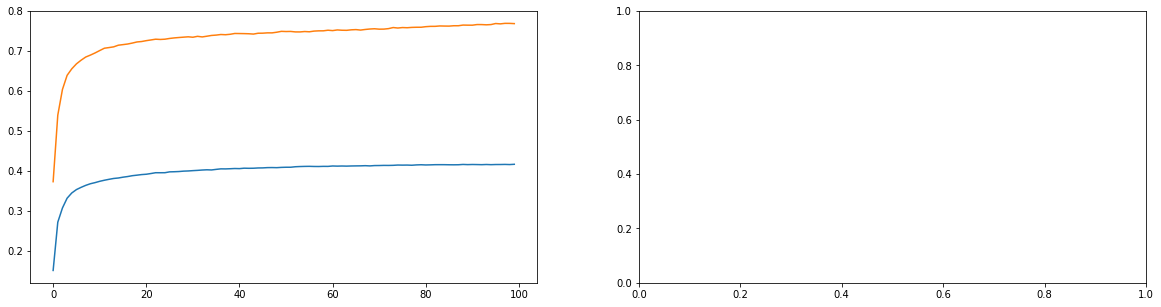

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.lineplot(x = range(len(trainer.eval_ndcg_list)),
             y = trainer.eval_ndcg_list,
             ax = axes[0])
sns.lineplot(x = range(len(trainer.train_ndcg_list)),
             y = trainer.train_ndcg_list,
             ax = axes[0])
plt.show()

# Inference

In [77]:
import torch
import numpy as np

In [78]:
import pandas as pd
def inference(trainer, data, k):
    
    best_model = trainer.model_best
    input_data = sparse2Tensor(trainer.inference_data).to(trainer.device)
    users = range(data.n_users)
    model.eval()
    
    with torch.no_grad():
        prediction = model(input_data, calculate_loss=False)
        print(prediction.size())
        prediction[torch.nonzero(input_data, as_tuple=True)] = -np.inf
        scores, movies = torch.topk(prediction, dim=1, k=k)
        
        users = np.tile(users, (k,1)).T
        user_list = np.concatenate([user for user in users])
        score_list = torch.cat([score for score in scores])
        movie_list = torch.cat([movie for movie in movies])
    
    user_decoder = {value : key for (key, value) in trainer.user_encoder.items()}
    item_decoder = {value : key for (key, value) in trainer.item_encoder.items()}
    
    inference_df = pd.DataFrame()
    inference_df['user'] = user_list
    inference_df['item'] = movie_list.cpu().numpy()
    inference_df['score'] = score_list.cpu().numpy()
    
    inference_df['user'] = inference_df['user'].apply(lambda x : user_decoder[x])
    inference_df['item'] = inference_df['item'].apply(lambda x : item_decoder[x])

    return inference_df

In [ ]:
inference_df = inference(trainer, data, k=6807)
inference_df = inference_df.sort_values(['user', 'score'], ascending=[True, False])

torch.Size([31360, 6807])


In [12]:
inference_df.to_csv('/opt/ml/input/code/_main/seunghwan/ensemble/voting_data/RecVAE.csv', index=False)

In [74]:
users = list(inference_df['user'].unique())
inference_df[inference_df['user'] == users[11]]

,user,item,score
285750,65,4878,5.044809
285751,65,2571,4.973499
285752,65,2858,4.818899
285753,65,1175,4.726315
285754,65,56367,4.581597
285755,65,2762,4.563349
285756,65,3949,4.540305
285757,65,527,4.530353
285758,65,32,4.505558
285759,65,48774,4.498129


In [75]:
best[best['user'] == users[11]]

,user,item
110,65,2571
111,65,4878
112,65,1175
113,65,2858
114,65,3949
115,65,7323
116,65,527
117,65,56367
118,65,2762
119,65,68954


In [36]:
SUB_PATH = '/opt/ml/input/code/_main/seunghwan/result/'

In [77]:
best = pd.read_csv(os.path.join(SUB_PATH, 'RecVAE_1.csv'))
a = best.sort_values(['user','item'])
b = inference_df.sort_values(['user','item'])

total = len(a)
miss = 0
for itema, itemb in zip(a['item'], b['item']) :
    if itema != itemb :
        miss += 1
        
print("miss : ", miss)
print("total : ", total)
print(f"sim : {miss / total * 100:.2f}%")

miss :  177806
total :  313600
sim : 56.70%


In [38]:
inference_df.drop('score', axis=1, inplace=True)
i = 1
while True :
    if os.path.exists(os.path.join(SUB_PATH, f'RecVAE_{i}.csv')) :
        i += 1
        continue
    inference_df.to_csv(os.path.join(SUB_PATH, f'RecVAE_{i}.csv'), index=False)
    break